# Access Computation

This tutorial demonstrates how to compute access.

## Setup

In [1]:
import sys

! {sys.executable} -m pip install --quiet numpy --upgrade
! {sys.executable} -m pip install --quiet plotly

# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryCorePy==0.1.9
# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryMathematicsPy==0.1.5
# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryPhysicsPy==0.1.3

In [2]:
import numpy as np
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [3]:
import Library.Core as Core
import Library.Mathematics as Mathematics
import Library.Physics as Physics
import Library.Astrodynamics as Astrodynamics

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

to-Python converter for library::physics::time::DateTime already registered; second conversion method ignored.



In [4]:
Length = Physics.Units.Length
Angle = Physics.Units.Angle
Scale = Physics.Time.Scale
Instant = Physics.Time.Instant
Duration = Physics.Time.Duration
Interval = Physics.Time.Interval
DateTime = Physics.Time.DateTime
LLA = Physics.Coordinate.Spherical.LLA
AER = Physics.Coordinate.Spherical.AER
Position = Physics.Coordinate.Position
Frame = Physics.Coordinate.Frame
Environment = Physics.Environment
Earth = Physics.Environment.Objects.CelestialBodies.Earth

Trajectory = Astrodynamics.Trajectory
Orbit = Astrodynamics.Trajectory.Orbit
Access = Astrodynamics.Access

---

## Access

An access represents an object-to-object visibility period.

In this example, let's compute accesses between a fixed position on the ground and a satellite in LEO.

### Origin

Let's define a fixed ground position, using its geographic coordinates:

In [47]:
# latitude = Angle.Degrees(37.0)
# longitude = Angle.Degrees(-122.0)
# altitude = Length.Meters(0.0)
latitude = Angle.Degrees(0.0)
longitude = Angle.Degrees(0.0)
altitude = Length.Meters(10.0)

In [48]:
from_lla = LLA(latitude, longitude, altitude)

In [49]:
from_position = Position.Meters(from_lla.toCartesian(Earth.EquatorialRadius, Earth.Flattening), Frame.ITRF())

And derive a trajectory, fixed at that position:

In [50]:
from_trajectory = Trajectory.Position(from_position)

### Target

Let's define the orbit of a satellite in LEO. In this example, we're modeling the orbit using SGP4.

First, we need a **Two-Line Element** (TLE) set:

In [51]:
# tle = Orbit.Models.SGP4.TLE("1 25544U 98067A   18231.17878740  .00000187  00000-0  10196-4 0  9994",
#                             "2 25544  51.6447  64.7824 0005971  73.1467  36.4366 15.53848234128316")
tle = Orbit.Models.SGP4.TLE("1 39419U 13066D   18248.44969859 -.00000394  00000-0 -31796-4 0  9997",
                            "2 39419  97.6313 314.6863 0012643 218.7350 141.2966 14.93878994260975")

To setup a **SGP4** orbital model:

In [52]:
orbital_model = Orbit.Models.SGP4(tle)

We then obtain the satellite orbit (which is a trajectory):

In [53]:
environment = Environment.Default()
satellite_orbit = Orbit(orbital_model, environment.accessCelestialObjectWithName("Earth"))

### Access

Now that the origin and the target trajectories is well defined, we can compute the access.

Let's first define an **interval of interest**:

In [54]:
start_instant = Instant.DateTime(DateTime.Parse("2018-09-06 04:45:17"), Scale.UTC) ;
end_instant = Instant.DateTime(DateTime.Parse("2018-09-07 04:45:17"), Scale.UTC) ;

interval = Interval.Closed(start_instant, end_instant) ;

And setup an environment (which describes where planets are, etc...):

In [55]:
environment = Physics.Environment.Default() ;

Then, using an **Access Generator**, we can compute the accesses within the intervals of interest:

In [56]:
access_generator = Access.Generator(environment) ;

accesses = access_generator.computeAccesses(interval, from_trajectory, satellite_orbit) ;

In [57]:
states = satellite_orbit.getStatesAt(access.getInterval().generateGrid(Duration.Minutes(1.0)))

And format the output using a dataframe:

In [58]:
accesses_df = pd.DataFrame([[str(access.getType()), repr(access.getAcquisitionOfSignal()), repr(access.getTimeOfClosestApproach()), repr(access.getLossOfSignal()), repr(access.getDuration())] for access in accesses], columns=['Type', 'AOS', 'TCA', 'LOS', 'Duration'])

In [59]:
accesses_df

,Type,AOS,TCA,LOS,Duration
0,Complete,2018-09-06 08:28:45 [UTC],2018-09-06 08:30:55 [UTC],2018-09-06 08:33:07 [UTC],04:22.000.000.000
1,Complete,2018-09-06 09:59:48 [UTC],2018-09-06 10:06:03 [UTC],2018-09-06 10:12:19 [UTC],12:31.000.000.000
2,Complete,2018-09-06 20:31:23 [UTC],2018-09-06 20:34:18 [UTC],2018-09-06 20:37:11 [UTC],05:48.000.000.000
3,Complete,2018-09-06 22:03:06 [UTC],2018-09-06 22:09:25 [UTC],2018-09-06 22:15:46 [UTC],12:40.000.000.000


In [60]:
accesses_df.head()

,Type,AOS,TCA,LOS,Duration
0,Complete,2018-09-06 08:28:45 [UTC],2018-09-06 08:30:55 [UTC],2018-09-06 08:33:07 [UTC],04:22.000.000.000
1,Complete,2018-09-06 09:59:48 [UTC],2018-09-06 10:06:03 [UTC],2018-09-06 10:12:19 [UTC],12:31.000.000.000
2,Complete,2018-09-06 20:31:23 [UTC],2018-09-06 20:34:18 [UTC],2018-09-06 20:37:11 [UTC],05:48.000.000.000
3,Complete,2018-09-06 22:03:06 [UTC],2018-09-06 22:09:25 [UTC],2018-09-06 22:15:46 [UTC],12:40.000.000.000


### Output

Let's calculate the geographic coordinate of the satellite, during access:

In [61]:
def compute_time_lla_aer_state (state):
    
    lla = LLA.Cartesian(state.getPosition().inFrame(Frame.ITRF(), state.getInstant()).getCoordinates(), Earth.EquatorialRadius, Earth.Flattening)
    
    aer = AER.FromPositionToPosition(from_position, state.getPosition().inFrame(Frame.ITRF(), state.getInstant()))

    return [state.getInstant(), float(lla.getLatitude().inDegrees()), float(lla.getLongitude().inDegrees()), float(lla.getAltitude().inMeters()), float(aer.getAzimuth().inDegrees()), float(aer.getElevation().inDegrees()), float(aer.getRange().inMeters())]

def compute_access_geometry (access):

    return [compute_time_lla_aer_state(state) for state in satellite_orbit.getStatesAt(access.getInterval().generateGrid(Duration.Minutes(1.0)))]

In [62]:
access_geometry_dfs = [pd.DataFrame(compute_access_geometry(access), columns=['Time', 'Latitude', 'Longitude', 'Altitude', 'Azimuth', 'Elevation', 'Range']) for access in accesses] ;

In [63]:
access_geometry_dfs[0].head()

,Time,Latitude,Longitude,Altitude,Azimuth,Elevation,Range
0,-- Instant -----------------------------------...,3.418715,23.444245,581703.976768,90.086040,-8.487623,2.794732e+06
1,-- Instant -----------------------------------...,-0.311860,22.696583,581775.474793,89.088980,0.803134,2.686053e+06
2,-- Instant -----------------------------------...,-4.042216,21.948594,582030.539217,88.640586,10.639088,2.641236e+06
3,-- Instant -----------------------------------...,-7.771636,21.196080,582466.895169,88.798201,20.559704,2.663928e+06
4,-- Instant -----------------------------------...,-11.499402,20.434691,583079.514042,89.642939,30.075499,2.752576e+06


And plot the geometries onto a map:

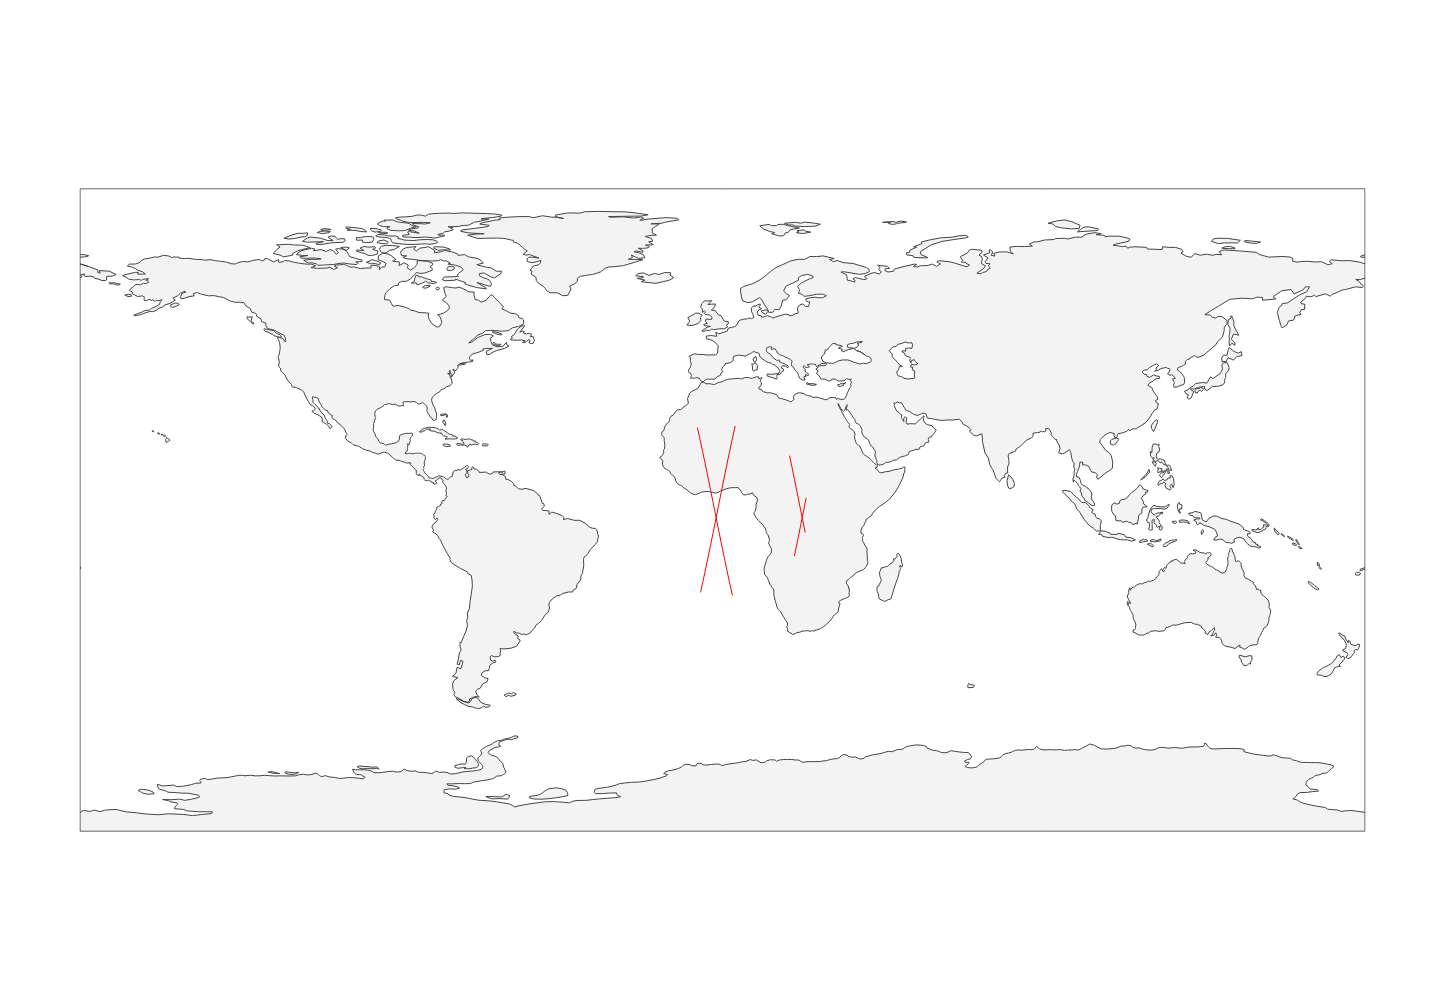

In [64]:
access_paths = []

for access_geometry_df in access_geometry_dfs:
    
    access_paths.append(
        dict(
            type = 'scattergeo',
            lon = access_geometry_df['Longitude'],
            lat = access_geometry_df['Latitude'],
            mode = 'lines',
            line = dict(
                width = 1,
                color = 'red',
            )
        )
    )
    
    if (len(access_paths) > 20):
        break
    
layout = dict(
        title = None,
        showlegend = False,
        height= 1000,
        geo = dict(
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )
    
fig = dict(data=access_paths, layout=layout)
iplot(fig)